In [1]:
from typing import Annotated
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END,StateGraph, START
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

d:\Project\AI\LangGraph\Lanchain_and_Langgraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dotenv import load_dotenv

In [3]:
load_dotenv()

True

## Loading the model

In [4]:
from langchain_groq import ChatGroq
#openai_model=ChatOpenAI(model="gpt-3.5-turbo")
groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [5]:
groq_model.invoke("hi").content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

In [6]:
def clean_text(text):
    import re
    clean_text = re.sub(r"<think>.*?</think>\s*", "", text, flags=re.DOTALL)
    return clean_text

In [7]:
response=groq_model.invoke("hi")

In [8]:
response.content

'<think>\n\n</think>\n\nHello! How can I assist you today?'

In [9]:
clean_text(response.content)

'Hello! How can I assist you today?'

In [10]:
tavaily_tool=TavilySearchResults()

C:\Users\Acer NItro 5\AppData\Local\Temp\ipykernel_12848\820692609.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavaily_tool=TavilySearchResults()


In [11]:
tavaily_tool.invoke("what is a gdp?")

[{'title': 'Gross domestic product - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Gross_domestic_product',
  'content': 'Gross domestic product (GDP) is a monetary measure of the total market value of all the final goods and services produced and rendered in a specific time period by a country or countries. GDP is often used to measure the economic activity of a country or region. The major components of GDP are consumption, government spending, net exports (exports minus imports), and investment. Changing any of these factors can increase the size of the economy. For example, population growth through mass [...] GDP (Y) is the sum of consumption (C), investment (I), government expenditures (G) and net exports (X − M).\n\n:   Y = C + I + G + (X − M)\n\nHere is a description of each GDP component: [...] GDP.',
  'score': 0.89997756},
 {'title': 'Gross Domestic Product - National Geographic Education',
  'url': 'https://education.nationalgeographic.org/resource/gross-domestic-prod

In [12]:
code = """
x = 5
y = x * 2
print(y)
"""

In [13]:
repl=PythonREPL()

In [14]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [15]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
C:\Users\Acer NItro 5\AppData\Local\Temp\ipykernel_12848\3901756031.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\Acer NItro 5\AppData\Local\Temp\ipykernel_12848\3901756031.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [16]:
print(python_repl_tool.invoke(code))

Successfully executed:
\`\`\`python

x = 5
y = x * 2
print(y)

\`\`\`
Stdout: 10



In [17]:
members=["researcher","coder"]

In [18]:
options=members+["FINISH"]

In [19]:
options

['researcher', 'coder', 'FINISH']

In [20]:
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal['researcher', 'coder', 'FINISH']

In [21]:
class State(MessagesState):
    next:str

In [22]:
system_prompt=f"""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [23]:
[{"role": "system", "content": system_prompt},]

[{'role': 'system',
  'content': "\nYou are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n"}]

In [24]:
state={"next":["hi"]}

In [25]:
state["next"]

['hi']

In [26]:
[{"role": "system", "content": system_prompt},] + state["next"]

[{'role': 'system',
  'content': "\nYou are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n"},
 'hi']

In [27]:
def supervisor_node(state: State) -> Command[Literal["researcher", "coder", "__end__"]]:
    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    response = groq_model.with_structured_output(Router).invoke(messages)
    
    goto = response["next"]
    
    print("below my goto**********************************")
    
    print(goto)
    
    if goto == "FINISH":
        goto = END
        
    return Command(goto=goto, update={"next": goto})

In [28]:
def research_node(state: State) -> Command[Literal["supervisor"]]:
    
    research_agent = create_react_agent(groq_model, tools=[tavaily_tool], prompt="You are a researcher. DO NOT do any math.")
    
    result = research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

In [29]:
def code_node(state: State) -> Command[Literal["supervisor"]]:
    
    code_agent = create_react_agent(groq_model, tools=[python_repl_tool])
    
    result = code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


In [30]:
graph=StateGraph(State)

In [31]:
graph.add_node("supervisor",supervisor_node)

In [32]:
graph.add_node("researcher", research_node)

In [33]:
graph.add_node("coder", code_node)

In [34]:
graph.add_edge(START,"supervisor")


In [35]:
app=graph.compile()

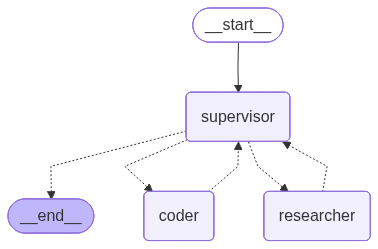

In [36]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [37]:
# With the graph created, we can now invoke it and see how it performs!
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("----")

below my goto**********************************
coder
((), {'supervisor': {'next': 'coder'}})
----
(('coder:ea4ef9e0-b959-2e6f-0598-5e0337a6f5a6',), {'agent': {'messages': [AIMessage(content="To find the square root of 42, I'll use Python's math module which provides a square root function.\n\n", additional_kwargs={'reasoning_content': "Alright, I need to find the square root of 42. I remember that the square root of a number is a value that, when multiplied by itself, gives the original number. So, for 42, I'm looking for a number which, when squared, equals 42. \n\nI know that 6 squared is 36 and 7 squared is 49. Since 42 is between 36 and 49, the square root of 42 must be between 6 and 7. To get a more precise value, I can use a calculator or a mathematical method like the Newton-Raphson method, but maybe I can approximate it manually.\n\nLet me try 6.5 squared. 6.5 times 6.5 is 42.25. That's a bit higher than 42, so the square root of 42 is a little less than 6.5. Maybe around 6.48

In [38]:
app.invoke({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True)

below my goto**********************************
researcher
below my goto**********************************
researcher


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': 'Okay, the user asked, "What\'s the square root of 42?" The researcher first calculated it as approximately 6.4807. Then, the coder confirmed the calculation, noting that 6.4807 squared is about 42. So, since both workers have contributed and confirmed the answer, I should now route to FINISH.'}}

In [39]:
app.invoke({"messages": [("user", "What is an efficient Python code to get prime numbers?")]}, subgraphs=True)

below my goto**********************************
researcher
below my goto**********************************
coder
below my goto**********************************
coder
below my goto**********************************
researcher
below my goto**********************************
coder
below my goto**********************************
coder
below my goto**********************************
coder


InternalServerError: Error code: 503 - {'error': {'message': 'deepseek-r1-distill-llama-70b is currently over capacity. Please try again and back off exponentially. Visit https://groqstatus.com to see if there is an active incident.', 'type': 'internal_server_error'}}